In [1]:
import math, torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from collections import deque

In [2]:
DEVICE        = 'cpu' 
T             = 500        # diffusion steps
BATCH_SIZE    = 512
TRAIN_ITERS   = 2000       # 訓練步數
LR            = 5e-4
HIDDEN        = 512
TIME_DIM      = 64
N_TRAIN_SAMP  = 10000       # 訓練資料量）


In [3]:
### Constants setting
betas = torch.linspace(1e-4, 0.02, T+1, device=DEVICE)
alphas = 1.0-betas
abar = torch.cumprod(alphas, dim=0)
sqrt_abar = torch.sqrt(abar)
sqrt_lmabar = torch.sqrt(1.0-abar)
sqrt_rcp_a = torch.sqrt(1.0 / alphas)

In [4]:
### 這塊留給 time embedding
#-------------------------
def sinusoidal_time_emb(t, dim):
    # t: (B,) 的整數 timestep
    device = t.device
    t = t.float().unsqueeze(1)  # (B,1)
    half = dim // 2
    freqs = torch.exp(
        torch.arange(half, device=device).float() * (-math.log(10000.0) / max(1, half-1))
    )  # (half,)
    angles = t * freqs  # (B,half)
    emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=1)  # (B, 2*half)
    if dim % 2 == 1:  # 補一維避免奇數維崩
        emb = torch.cat([emb, torch.zeros_like(emb[:, :1])], dim=1)
    return emb  # (B, dim)

In [5]:
## 建nn
class EpsMLP(nn.Module):
    def __init__(self, hidden=HIDDEN, time_dim=TIME_DIM):
        super().__init__()
        self.time_dim = time_dim
        # 把 time embedding 投影到hidden layer
        self.t_proj = nn.Sequential(
            nn.Linear(time_dim, hidden), 
            nn.SiLU()
            )
        
        # y_t(1維) + time(hidden) → hidden → 1維噪聲預測
        in_dim = hidden + 1 # y+dim=1
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden),
            nn.SiLU(),
            nn.Linear(hidden,1)
        )
    def forward(self, y_t, t):
        t_emb = sinusoidal_time_emb(t, self.time_dim)   # (B, time_dim)
        h_t = self.t_proj(t_emb)                        # (B, hidden)
        h = torch.cat([y_t, h_t], dim=1)                # (B, 1+hidden)
        return self.net(h)

model = EpsMLP().to(DEVICE)
opt = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=TRAIN_ITERS, eta_min=1e-5)  ###<---10/1新增

In [6]:
### 計算 y_t= sqrt(abar_t) y0 + sqrt(1-abar_t) * eps
# ---------------------
def q_sample(y0, t, eps=None):
    if eps is None:
        eps = torch.randn_like(y0)   ## 產生跟y0大小一樣的初始normal雜訊
    sa = sqrt_abar[t].view(-1,1)
    som = sqrt_lmabar[t].view(-1,1)
    return sa*y0+som*eps, eps


In [7]:
def train_loop(record_step):
    model.train()
    losses =[]
    movavg =[]
    ma=deque(maxlen=50) #長度為50的mov_avg frame

    for step in range(1, TRAIN_ITERS+1):
        # 取 y0~N(0,1)
        y0 = torch.randn(BATCH_SIZE, 1, device=DEVICE)
        # 隨機time step
        t = torch.randint(2,T+1, (BATCH_SIZE,),device=DEVICE).long()
        # 向前加噪
        y_t, eps = q_sample(y0,t)
        # 預測噪音
        eps_hat = model(y_t, t)     
        loss = F.mse_loss(eps_hat, eps)

        opt.zero_grad(set_to_none = True) 
        loss.backward()
        #把L2norm限制在1.0以內避免梯度爆炸 ; 但如果loss穩定可以不用
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        if step % record_step ==0: 
            val = loss.detach().item()
            losses.append(val)
            ma.append(val)
            movavg.append(sum(ma)/len(ma))
            print(f"[train] step {step:4d} | loss {loss.item():.6f}")
    
    
    return losses, movavg

In [8]:
#@torch.no_grad() 是 PyTorch 的一個 decorator（裝飾器），加在函式前面，意思是：
#在這個函式裡面所有的張量運算，都不會被 autograd 記錄梯度。
#這樣可以減少計算消耗

@torch.no_grad()
def sample_on_grid(n_points = 401):
    model.eval()
    # 初始化 y 的 batch，要用 n_points
    y = torch.randn(n_points, 1, device=DEVICE)  ## 直接在N(0,1)裡面抽東西就好
    for t in reversed(range(T+1)):
        tb = torch.full((n_points,), t, device=DEVICE, dtype=torch.long)
        eps_hat = model(y, tb)  ###<<<---已拿掉x
        mean = sqrt_rcp_a[t]*(y - (betas[t]/sqrt_lmabar[t]) * eps_hat) #那行公式
        if t>0:
            y = mean + torch.sqrt(betas[t])*torch.randn_like(y)
        ###<----拿掉else
    
    return y.squeeze(1).cpu() 

[train] step    1 | loss 1.029941
[train] step    2 | loss 0.877108
[train] step    3 | loss 0.951230
[train] step    4 | loss 0.942392
[train] step    5 | loss 0.894908
[train] step    6 | loss 0.873007
[train] step    7 | loss 0.847724
[train] step    8 | loss 0.780713
[train] step    9 | loss 0.820794
[train] step   10 | loss 0.789617
[train] step   11 | loss 0.688221
[train] step   12 | loss 0.729837
[train] step   13 | loss 0.760676
[train] step   14 | loss 0.642937
[train] step   15 | loss 0.692704
[train] step   16 | loss 0.597946
[train] step   17 | loss 0.587806
[train] step   18 | loss 0.575594
[train] step   19 | loss 0.506050
[train] step   20 | loss 0.655267
[train] step   21 | loss 0.431506
[train] step   22 | loss 0.480310
[train] step   23 | loss 0.602991
[train] step   24 | loss 0.497077
[train] step   25 | loss 0.490598
[train] step   26 | loss 0.569137
[train] step   27 | loss 0.454544
[train] step   28 | loss 0.485992
[train] step   29 | loss 0.454840
[train] step  

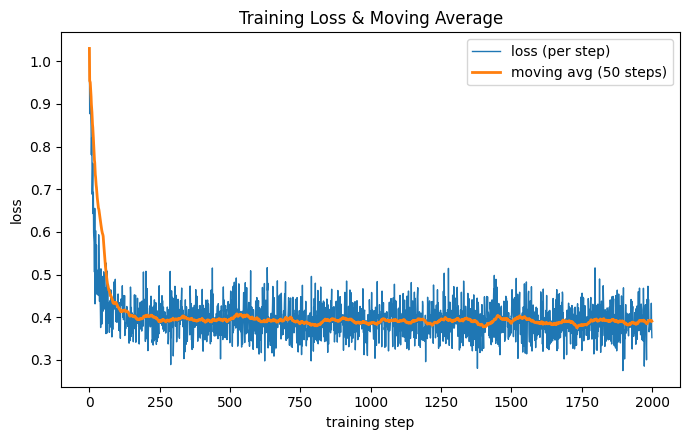

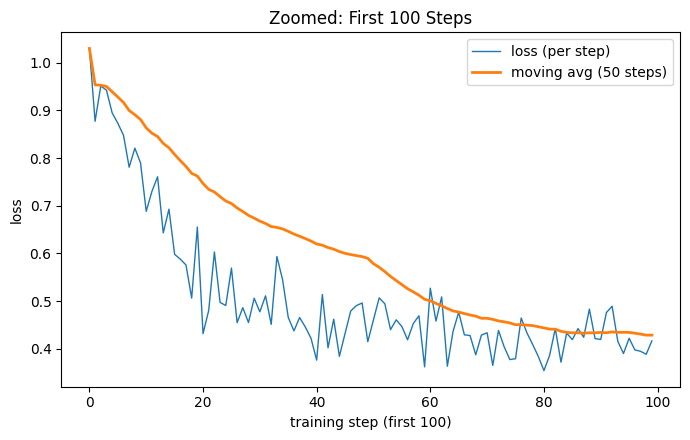

In [9]:
losses, movavg=train_loop(record_step=1)
steps = np.arange(len(losses))
y_hat = sample_on_grid(n_points = 1000)

# 全部步數
plt.figure(figsize=(7,4.5))
plt.plot(steps, losses, label="loss (per step)", linewidth=1)
plt.plot(steps, movavg, label="moving avg (50 steps)", linewidth=2)
plt.xlabel("training step")
plt.ylabel("loss")
plt.title("Training Loss & Moving Average")
plt.legend()
plt.tight_layout()
plt.show()

# 前 100 步局部放大（線性 y 軸）
k = min(100, len(losses))
plt.figure(figsize=(7,4.5))
plt.plot(steps[:k], losses[:k], label="loss (per step)", linewidth=1)
plt.plot(steps[:k], movavg[:k], label="moving avg (50 steps)", linewidth=2)
plt.xlabel("training step (first 100)")
plt.ylabel("loss")
plt.title("Zoomed: First 100 Steps")
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
print(type(opt))
for i, g in enumerate(opt.param_groups):
    print(f"group {i} lr={g['lr']}")

<class 'torch.optim.adamw.AdamW'>
group 0 lr=0.0005


In [11]:
y_true = torch.randn(1000, 1, device=DEVICE)

print("y_hat: ", y_hat)
print("y_true: ", y_true)   

y_hat:  tensor([ 8.0164e-01, -6.7408e-01, -2.2235e+00, -1.1189e+00, -1.3609e+00,
         4.6942e-01, -3.7537e-01,  1.4000e+00,  1.4916e+00, -3.8712e-01,
         1.2327e+00, -2.1420e-01, -9.6802e-01,  9.9783e-01,  9.0630e-01,
         2.6025e-01,  5.2099e-01,  7.9157e-01,  7.7073e-01, -5.6462e-01,
        -6.4624e-01,  1.8542e+00,  9.5948e-01,  1.4443e-01, -1.0502e+00,
        -2.4922e-01,  1.1653e+00,  2.2513e+00, -5.6607e-01,  2.4001e-01,
         1.7607e+00, -2.3260e+00, -9.3404e-01, -1.7714e+00,  7.2700e-01,
         1.7561e+00, -1.0041e+00,  1.5220e+00,  1.6933e-01, -7.2929e-01,
         8.7655e-01, -1.8044e+00,  1.6586e+00,  2.6783e-03, -6.7813e-01,
        -6.8631e-01,  6.2233e-01,  3.1680e-01,  1.5240e+00,  7.5580e-01,
         3.7295e-01,  3.3646e-01,  8.1977e-01, -1.6564e+00, -3.1979e-01,
         4.9013e-01,  4.4265e-01, -3.4626e-02,  5.1843e-01, -1.4990e-01,
        -1.2686e+00, -1.3277e+00, -3.1606e-01, -1.2090e+00, -4.5417e-01,
        -3.0541e-01, -1.5919e+00,  1.2979e-

In [12]:
print(type(y_hat))
print(y_hat.shape)
print(y_true.shape)

<class 'torch.Tensor'>
torch.Size([1000])
torch.Size([1000, 1])


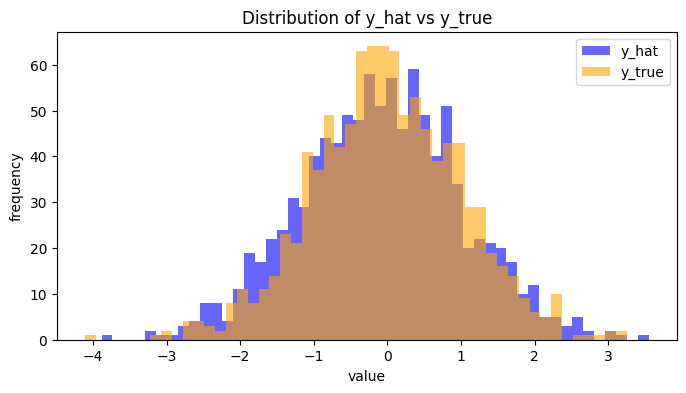

In [13]:
import matplotlib.pyplot as plt

# 如果在 GPU，要先搬回 CPU
y_hat_np = y_hat.detach().cpu().numpy().flatten()
y_true_np = y_true.detach().cpu().numpy().flatten()

plt.figure(figsize=(8,4))

# 畫 y_hat 的直方圖
plt.hist(y_hat_np, bins=50, alpha=0.6, color='blue', label='y_hat')

# 畫 y_true 的直方圖
plt.hist(y_true_np, bins=50, alpha=0.6, color='orange', label='y_true')

plt.legend()
plt.xlabel("value")
plt.ylabel("frequency")
plt.title("Distribution of y_hat vs y_true")
plt.show()


In [14]:
import numpy as np
from scipy.stats import ks_2samp, epps_singleton_2samp, levene, ttest_ind

In [15]:
# 1) 取資料（確保 shape 與裝置一致）
y_hat_np  = y_hat.detach().cpu().numpy().ravel()
y_true_np = y_true.detach().cpu().numpy().ravel()

# 2) 可選：讓樣本數一致（避免樣本量差異影響）
n = min(len(y_hat_np), len(y_true_np))
rng = np.random.default_rng(0)
y_hat_s  = rng.choice(y_hat_np,  n, replace=False)
y_true_s = rng.choice(y_true_np, n, replace=False)

# 3) 兩樣本分布檢定
ks_stat, ks_p = ks_2samp(y_hat_s, y_true_s)                 # KS 檢定（對整體CDF差異敏感）
es_stat, es_p = epps_singleton_2samp(y_hat_s, y_true_s)     # Epps–Singleton（對形狀差更敏感）

# 4) 均值、變異的簡單比較（非必要，但有助判讀差異來源）
t_stat, t_p   = ttest_ind(y_hat_s, y_true_s, equal_var=False)
lev_stat, lev_p = levene(y_hat_s, y_true_s)                 # 變異是否相等

print(f"KS: stat={ks_stat:.3f}, p={ks_p:.3g}")
print(f"Epps–Singleton: stat={es_stat:.3f}, p={es_p:.3g}")
print(f"t-test (means): stat={t_stat:.3f}, p={t_p:.3g}")
print(f"Levene (variances): stat={lev_stat:.3f}, p={lev_p:.3g}")

# 5) 幾個摘要統計（幫助你直覺比較）
def summary(a, name):
    print(name, "mean=", np.mean(a), "std=", np.std(a), "kurtosis≈", (np.mean(((a-np.mean(a))/np.std(a))**4)-3))
summary(y_hat_s,  "y_hat")
summary(y_true_s, "y_true")


KS: stat=0.053, p=0.121
Epps–Singleton: stat=9.806, p=0.0438
t-test (means): stat=-1.534, p=0.125
Levene (variances): stat=7.113, p=0.00771
y_hat mean= -0.082045406 std= 1.0978477 kurtosis≈ 0.001447916
y_true mean= -0.009381373 std= 1.0180664 kurtosis≈ 0.34403896


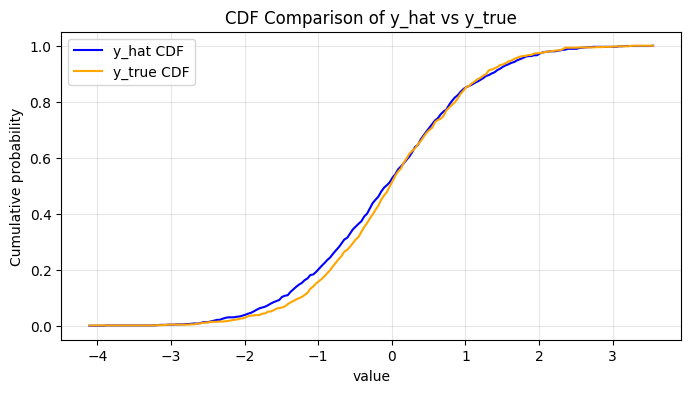

In [16]:
def plot_cdf_comparison(y_hat, y_true, bins=200):
    # 轉 numpy
    y_hat_np  = y_hat.detach().cpu().numpy().ravel()
    y_true_np = y_true.detach().cpu().numpy().ravel()

    # 共同範圍
    lo = min(y_hat_np.min(), y_true_np.min())
    hi = max(y_hat_np.max(), y_true_np.max())
    grid = np.linspace(lo, hi, bins)

    # 計算 CDF
    y_hat_cdf  = np.searchsorted(np.sort(y_hat_np), grid, side="right") / len(y_hat_np)
    y_true_cdf = np.searchsorted(np.sort(y_true_np), grid, side="right") / len(y_true_np)

    
    plt.figure(figsize=(8,4))
    plt.plot(grid, y_hat_cdf, label="y_hat CDF", color="blue")
    plt.plot(grid, y_true_cdf, label="y_true CDF", color="orange")
    plt.xlabel("value")
    plt.ylabel("Cumulative probability")
    plt.title("CDF Comparison of y_hat vs y_true")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


plot_cdf_comparison(y_hat, y_true)
